In [1]:
import altair as alt
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
from sqlalchemy import text

plt.style.use("ggplot")

In [2]:
pg_eng = nivapy.da.connect_postgis()

Connection successful.


# Exploring TEOTIL3 runoff

Several people have commented that the runoff estimates from TEOTIL3 seem too high, and runoff in TEOTIL3 is certainly higher than in TEOTIL2. This notebook does some basic exploration and checking.

## 1. Method changes

Runoff is estimated differently in TEOTIL2 versus TEOTIL3. In brief:

 * **TEOTIL2:** Uses regine average runoff estimates for 1961 to 1990, and scales them such that the total discharge from each vassdragsområde in each year is equal to the total discharge simulated by NVE's HBV model.
   
 * **TEOTIL3:** A scaling factor is derived by comparing HBV results for the year of interest to the mean HBV output for 1991 to 2020. This scaling factor is applied to regine average runoff estimates for 1991 to 2020.

In both models, the temporal variability in simulated annual discharges comes from the HBV data. The main difference is that TEOTIL2 always simulates the same vassdragsområde level annual totals as HBV, whereas TEOTIL3 simulates totals based primarily on the 1991-2020 runoff grid.

In [3]:
st_yr, end_yr = 2013, 2022

## 2. HBV simulations for vassdragsområder

Daily resolution HBV simulations for each vassdragsområde from 1990 to present are delivered by NVE each year.

In [4]:
# Read HBV data delivered in 2023
sql = text("SELECT * FROM teotil3.nve_hbv_discharge WHERE data_supply_year = 2023")
hbv_df = pd.read_sql(sql, pg_eng)
hbv_df = hbv_df[["vassom", "date", "flow_m3/s"]]
hbv_df.columns = ["vassom", "date", "hbv_flow_m3ps"]
hbv_df["year"] = hbv_df["date"].dt.year
hbv_df = hbv_df.query("year >= @st_yr")

# Annual means
hbv_df = hbv_df.groupby(["vassom", "year"]).mean(numeric_only=True).reset_index()
hbv_df = hbv_df.sort_values(["vassom", "year"])
hbv_df.head()

,vassom,year,hbv_flow_m3ps
0,001,2013,31.887461
1,001,2014,47.569752
2,001,2015,43.683483
3,001,2016,26.704522
4,001,2017,24.836945


## 3. TEOTIL2 simulations for vassdragsområder

The TEOTIL2 mean flows should match the HBV data (see method description above).

In [5]:
# TEOTIL2 annual flows
vassoms = [f"{id:03d}." for id in range(1, 248)] + [
    f"{id:03d}." for id in range(301, 316)
]
years = range(st_yr, end_yr + 1)

# Get regine-level data
df_list = []
for year in years:
    teo2_csv = f"/home/jovyan/shared/common/JES/teotil2/data/norway_annual_output_data/teotil2_results_{year}.csv"
    teo2_df = pd.read_csv(teo2_csv)
    teo2_df.rename(columns={"accum_q_m3/s": "teo2_flow_m3ps"}, inplace=True)
    teo2_df["year"] = year
    teo2_df = teo2_df[["regine", "year", "teo2_flow_m3ps"]]
    df_list.append(teo2_df)
teo2_df = pd.concat(df_list, axis="rows")

# Extract results for vassoms
teo2_vassom_df = teo2_df.query("regine in @vassoms").copy()
teo2_vassom_df.rename(columns={"regine": "vassom"}, inplace=True)
teo2_vassom_df["vassom"] = teo2_vassom_df["vassom"].str[:3]
teo2_vassom_df = (
    teo2_vassom_df[["vassom", "year", "teo2_flow_m3ps"]]
    .sort_values(["vassom", "year"])
    .reset_index(drop=True)
)
teo2_vassom_df.head()

,vassom,year,teo2_flow_m3ps
0,001,2013,31.887461
1,001,2014,47.569752
2,001,2015,43.683483
3,001,2016,26.704522
4,001,2017,24.836945


## 4. TEOTIL3 simulations for vassdragsområder

The TEOTIL3 mean flows are based on the updated 1991-2020 runoff grid, but with temporal variation inferred from the HBV simulations. The TEOTIL3 totals therefore do not necessarily match the HBV totals. 

In [6]:
# Get regine-level data
teo3_csv = f"/home/jovyan/shared/common/teotil3/evaluation/teo3_results_nve2023_2013-2022_agri-annual-loss.csv"
teo3_df = pd.read_csv(teo3_csv)[["regine", "year", "accum_q_m3/s"]]
teo3_df.columns = ["regine", "year", "teo3_flow_m3ps"]

# Extract results for vassoms
teo3_vassom_df = teo3_df.query("regine in @vassoms").copy()
teo3_vassom_df.rename(columns={"regine": "vassom"}, inplace=True)
teo3_vassom_df["vassom"] = teo3_vassom_df["vassom"].str[:3]
teo3_vassom_df = (
    teo3_vassom_df[["vassom", "year", "teo3_flow_m3ps"]]
    .sort_values(["vassom", "year"])
    .reset_index(drop=True)
)
teo3_vassom_df.head()

,vassom,year,teo3_flow_m3ps
0,001,2013,38.292191
1,001,2014,57.124336
2,001,2015,52.457491
3,001,2016,32.068238
4,001,2017,29.825550


## 5. Combine and compare

In [7]:
# Join
vassom_df = pd.merge(hbv_df, teo2_vassom_df, how="left", on=["vassom", "year"])
vassom_df = pd.merge(vassom_df, teo3_vassom_df, how="left", on=["vassom", "year"])
vassom_df.head()

,vassom,year,hbv_flow_m3ps,teo2_flow_m3ps,teo3_flow_m3ps
0,001,2013,31.887461,31.887461,38.292191
1,001,2014,47.569752,47.569752,57.124336
2,001,2015,43.683483,43.683483,52.457491
3,001,2016,26.704522,26.704522,32.068238
4,001,2017,24.836945,24.836945,29.825550


In [8]:
vassom_df.describe()

,year,hbv_flow_m3ps,teo2_flow_m3ps,teo3_flow_m3ps
count,2610.000000,2610.000000,2610.000000,2610.000000
mean,2017.500000,38.953074,38.953074,54.840910
std,2.872832,57.962967,57.963478,73.979428
min,2013.000000,0.000000,0.000000,0.461650
25%,2015.000000,10.703712,10.703712,16.803716
50%,2017.500000,23.310827,23.310827,34.995211
75%,2020.000000,45.113449,45.113449,61.950187
max,2022.000000,742.945883,742.945883,924.231192


<Axes: >

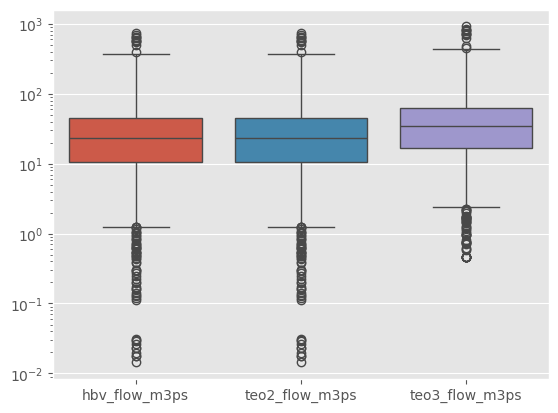

In [9]:
sn.boxplot(data=vassom_df.drop(columns=["vassom", "year"]), log_scale=True)

TEOTIL2 matches the HBV simulations exactly (as expected), while flows simulated by TEOTIL3 are consistently a bit higher. **Which is correct?**

In some areas, there are known issues with HBV (and therefore TEOTIL2) underestimating runoff. For example, in vassdragsområde 057, HBV and TEOTIL2 estimate mean annual flows of around 4.2 m3/s, whereas TEOTIL3 estimates about 12.4 m3/s. According to Stein Beldring, the latter value (from TEOTIL3) is considered more reasonable - see e-mail received 09.10.2022 and the issue [here](https://github.com/NIVANorge/teotil3/issues/15) for details. The problem is that HBV doesn't resolve land well in some coastal vassdragsområder, leading to significant underestimation of flows.

Another issue is that, in the east, the regine dataset extends into Sweden, but the HBV simulations stop just over the border. In these areas, flow totals from HBV dramatically underestimate actual flows, because only a small part of the true catchment is included in NVE's modelling. For example, for vassdragsområde 301, the HBV simulated flows are 0.5% of what would be expected based on the land area and mean runoff from 1961-90 (see issue [here](https://github.com/NIVANorge/teotil3/issues/15) for details).

The plot below compares flows from HBV and TEOTIL3 for all years and vassdragsområder.

In [10]:
# Compare TEOTIL3 with HBV
scatter = (
    alt.Chart(vassom_df)
    .mark_point()
    .encode(
        x="hbv_flow_m3ps",
        y="teo3_flow_m3ps",
        color="vassom",
        tooltip=["vassom", "year", "hbv_flow_m3ps", "teo3_flow_m3ps"],
    )
    .properties(title="Flow Comparison")
    .interactive()
)
line = (
    alt.Chart(vassom_df)
    .mark_line(color="black")
    .encode(x="hbv_flow_m3ps", y="hbv_flow_m3ps")
)
chart = scatter + line
chart

/opt/conda/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

It is notable that TEOTIL3 almost always simulates higher flows than HBV (and therefore than TEOTIL2). The biggest differences are in vassdragsområder along the Swedish border, where the TEOTIL3 simulations should definitely be better than those in TEOTIL2/HBV. However, it is clear that TEOTIL3 simulates higher discharges even in large catchments tat are wholly within Norway - Glomma, for example.

The big question, then, is **which model simulates observed flows best**? The best way to test this is to compare annual flow simulations for a specific regine with observed data series from NVE.

In [11]:
# Choose a TEOTIL regine and a corresponding NVE monitoring
# station with data available in HydAPI
reg_id = "002.B7"
nve_id = "2.605.0"  # Glomma ved Solbergfoss

# Get TEOTIL2 results
teo2_reg_df = teo2_df.query("regine == @reg_id").copy()
del teo2_reg_df["regine"]

# Get TEOTIL3 results
teo3_reg_df = teo3_df.query("regine == @reg_id").copy()
del teo3_reg_df["regine"]

# Get observed data
obs_df = nivapy.da.query_nve_hydapi(
    [nve_id], [1001], f"{st_yr}-01-01", f"{end_yr + 1}-01-01", resolution=1440
)[["datetime", "value"]]
obs_df["year"] = obs_df["datetime"].dt.year
obs_df = obs_df.groupby("year").mean().reset_index()[["year", "value"]]
obs_df.columns = ["year", "obs_flow_m3ps"]

q_df = pd.merge(obs_df, teo2_reg_df, how="left", on="year")
q_df = pd.merge(q_df, teo3_reg_df, how="left", on="year")
q_df = q_df.set_index("year")
q_df

,obs_flow_m3ps,teo2_flow_m3ps,teo3_flow_m3ps
year,,,
2013,729.264619,553.201779,690.210349
2014,867.131119,655.673387,818.060574
2015,775.713631,603.300808,752.717142
2016,643.058817,477.954307,596.326733
2017,736.979634,549.056127,685.037987
2018,691.798935,624.651381,779.355503
2019,763.218219,622.628057,776.831070
2020,846.399612,710.927892,886.999642
2021,740.724915,565.925596,706.085406


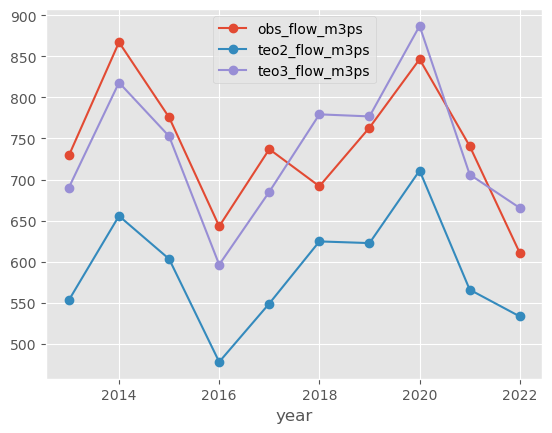

In [12]:
# Time series plot
q_df.plot(marker="o");

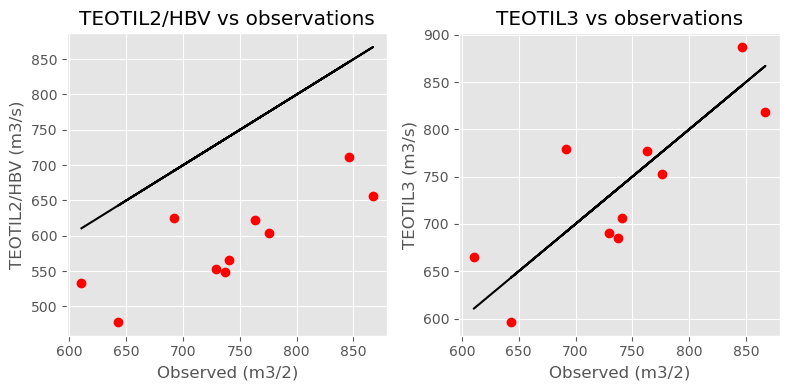

In [13]:
# Scatterplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes[0].plot(q_df["obs_flow_m3ps"], q_df["teo2_flow_m3ps"], "ro")
axes[0].plot(q_df["obs_flow_m3ps"], q_df["obs_flow_m3ps"], "k-", label="1:1 line")
axes[0].set_title("TEOTIL2/HBV vs observations")
axes[0].set_xlabel("Observed (m3/2)")
axes[0].set_ylabel("TEOTIL2/HBV (m3/s)")

axes[1].plot(q_df["obs_flow_m3ps"], q_df["teo3_flow_m3ps"], "ro")
axes[1].plot(q_df["obs_flow_m3ps"], q_df["obs_flow_m3ps"], "k-", label="1:1 line")
axes[1].set_title("TEOTIL3 vs observations")
axes[1].set_xlabel("Observed (m3/2)")
axes[1].set_ylabel("TEOTIL3 (m3/s)")
plt.tight_layout()

Based on this, it seems clear that TEOTIL3 performs better than either TEOTIL2 or HBV. In other words, the updated runoff grid for 1991-2020 provides a better basis for estimating total runoff volume than the HBV simulations (which have a tendency to underestimate). There is no obvious bias in TEOTIL3, compared to an obvious underestimation bias in TEOTIL2 and HBV.

These results are consistent with other assessments for TEOTIL3, which typically performs well at simulating annual runoff - see, for  example, the evaluation presented in `T2-15b_compare_measured_fluxes.ipynb` in this repositiory, or notebook `01_check_runoff.ipynb` in the `teotil3_trondheimsfjorden` repository.